## First stab at visualizing ATL03, ATL06


In [115]:
import pandas as pd
import geopandas as gpd
import h5py
import glob
import os
import matplotlib.pyplot as plt
# from bokeh.plotting import figure, output_file, show
# from bokeh.models import ColumnDataSource, LinearColorMapper
import numpy as np
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoData, LayersControl
import geopandas
import json

In [116]:
import getpass

def list_files_local(path):
    """ Get file list form local folder. """
    from glob import glob
    return glob(path)


In [117]:
prodname = 'ATL06'
site = 'seeps'
path2files = str('/home/jovyan/' + prodname + '/' + site + '/')
# print(path2files)
hdf5_flist = glob.glob(str(path2files +'*.h5'))
# print(hdf5_flist)
f = h5py.File(hdf5_flist[0], 'r')
print(f)

<HDF5 file "processed_ATL06_20190114020111_02540205_001_01.h5" (mode r)>


In [151]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """ Converte GPS time to decimal years. """
    return Time(time, format='gps').decimalyear

def track_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  i_asc[i_track] = True
    
    return i_asc, np.invert(i_asc)  # index vectors


def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


In [118]:
import matplotlib.pyplot as plt
%matplotlib widget

def read_h5(fname, vnames=[]):
    """ Simple HDF5 reader. """
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]

In [148]:
# files = list_files_local(path2files)
# print(files)
fname = hdf5_flist[1]
print(fname)

#!h5ls -r /home/jovyan/ATL06/seeps/processed_ATL06_20181030170315_04900103_001_01.h5
# !h5ls -r /home/jovyan/ATL03/seeps/processed_ATL03_20190202123455_05510203_001_01.h5


/home/jovyan/ATL06/seeps/processed_ATL06_20181030170315_04900103_001_01.h5


In [169]:
import h5py
import numpy as np

def read_atl06(fname, bbox=None):
    """ 
    Read 1 ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
    # Loop trough beams
    for k,g in enumerate(group):

        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            #print(fi[g].keys())
            if g+'/land_ice_segments' in fi.keys():
                #print('Found some data on beam' + g)
                #print(fi[g+'/land_ice_segments'].keys())                

                lat = fi[g+'/land_ice_segments/latitude'][:]
                lon = fi[g+'/land_ice_segments/longitude'][:]
                h_li = fi[g+'/land_ice_segments/h_li'][:]
                s_li = fi[g+'/land_ice_segments/h_li_sigma'][:]
                t_dt = fi[g+'/land_ice_segments/delta_time'][:]
                q_flag = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
                t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]
                rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat))
                orb = np.full_like(h_li, k)

                #---------------------------------------------#
                # 2) Filter data according region and quality #
                #---------------------------------------------#

                # Select a region of interest
                if bbox:
                    lonmin, lonmax, latmin, latmax = bbox
                    bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                                (lat >= latmin) & (lat <= latmax)
                else:
                    bbox_mask = np.ones_like(lat, dtype=bool)  # get all

                # Only keep good data, and data inside bbox
                mask = (q_flag == 0) & (np.abs(h_li) < 10e3) & (bbox_mask == 1)

                # Update variables
                lat, lon, h_li, s_li, t_dt, rgt, orb = \
                    lat[mask], lon[mask], h_li[mask], s_li[mask], t_dt[mask],\
                        rgt[mask], orb[mask]

                # Test for no data
                if len(h_li) == 0: continue

                #-------------------------------------#
                # 3) Convert time and separate tracks #
                #-------------------------------------#

                # Time in GPS seconds (secs sinde 1980...)
                t_gps = t_ref + t_dt

                # Time in decimal years
                t_year = gps2dyr(t_gps)

                # Determine orbit type
                i_asc, i_des = track_type(t_year, lat)

                #-----------------------#
                # 4) Save selected data #
                #-----------------------#

                # Define output file name
                ofile = fname.replace('.h5', '_'+g[1:]+'.h5')

                # Save variables
                with h5py.File(ofile, 'w') as f:
                    f['orbit'] = orb
                    f['lon'] = lon
                    f['lat'] = lat
                    f['h_elv'] = h_li
                    f['t_year'] = t_year
                    f['t_sec'] = t_gps
                    f['s_elv'] = s_li
                    f['q_flg'] = q_flag
                    f['rgt'] = rgt
                    f['trk_type'] = i_asc

                    print('out ->', ofile)
                

In [74]:
import h5py
import numpy as np

def read_atl03(fname, bbox=None):
    print(fname)
    """ 
    Read 1 ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """
    f = h5py.File(fname,'r')
    print(f.keys())
    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
    # Loop trough beams
    for k,g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            if g+'/heights' in fi.keys():
                lat = fi[g+'/heights/lat_ph'][:]
                lon = fi[g+'/heights/lon_ph'][:]
                h = fi[g+'/heights/h_ph'][:]
                conf = fi[g+'/heights/signal_conf_ph']

                land_ice_class = conf[:,3]
          
        #-----------------------------------#
        # 3) Filter data #
        #-----------------------------------#
                mask = (land_ice_class == 4) & (np.abs(h) < 10e3)
                lat,lon,h = lat[mask],lon[mask],h[mask]
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
                ofile = fname.replace('.h5', '_'+g[1:]+'.h5')
                
        # Save variables
                with h5py.File(ofile, 'w') as f:
                    f['lon'] = lon
                    f['lat'] = lat
                    f['h_elv'] = h
            
                    print('out ->', ofile)
                

In [170]:
# print(hdf5_flist)
for ii in range(0,len(hdf5_flist)):
    print('file number ' + str(ii) + ' is ' + hdf5_flist[ii])
    read_atl06(hdf5_flist[ii])

file number 0is /home/jovyan/ATL06/seeps/processed_ATL06_20190114020111_02540205_001_01.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20190114020111_02540205_001_01_gt1l.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20190114020111_02540205_001_01_gt1r.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20190114020111_02540205_001_01_gt2l.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20190114020111_02540205_001_01_gt2r.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20190114020111_02540205_001_01_gt3l.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20190114020111_02540205_001_01_gt3r.h5
file number 1is /home/jovyan/ATL06/seeps/processed_ATL06_20181030170315_04900103_001_01.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20181030170315_04900103_001_01_gt1l.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20181030170315_04900103_001_01_gt1r.h5
out -> /home/jovyan/ATL06/seeps/processed_ATL06_20181030170315_04900103_001_01_gt2l.h5
out -> /home/jovyan/ATL06/seeps/pro

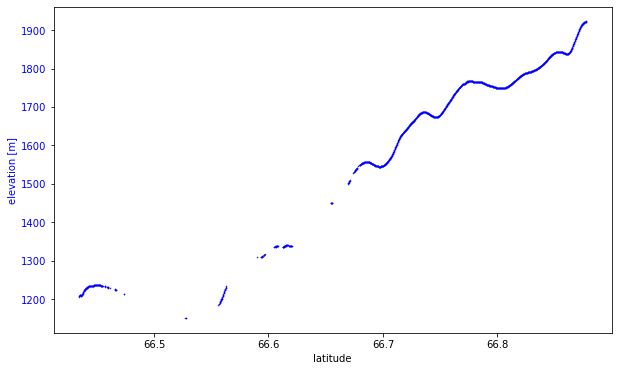

In [183]:
hdf_files_by_laser = list_files_local(path2files + '*gt*.h5')
#!h5ls -r /home/jovyan/ATL06/seeps/processed_ATL06_20190125125128_04290203_001_01_gt2r.h5

#print(hdf_files_by_laser)
for ii in range(0, len(hdf_files_by_laser)):
    with h5py.File(hdf_files_by_laser[ii]) as f:
        elev_atl06 = f['h_elv'][:]
        lat_atl06 = f['/lat'][:]
        lon_atl06 = f['/lon'][:]
        #background_atl06 = f['/gt2l/land_ice_segments/geophysical/bckgrd'][:]
        #ebackground_atl06 = f['/gt2l/land_ice_segments/geophysical/e_bckgrd'][:]
        f.close()

#backmax = max(background_atl06[subset2])

%matplotlib inline
f1, ax = plt.subplots(figsize=(10,6))

ax.scatter(lat_atl06, lonelev_atl06, 'b.', markersize=1)
ax.set_xlabel('latitude')
ax.set_ylabel('elevation [m]', color='b')
ax.tick_params(axis='y', labelcolor='b')

#testharder
#f1.tight_layout
plt.show()